# Lab — Deep Graph Generative Models

In this lab we consider deep graph generation model on synthetic dataset.

### Mini graph classification dataset

First, define the custom dataset based on DGL MiniGCDataset.

In [1]:
#!pip install dgl-cu111 -f https://data.dgl.ai/wheels/repo.html -q
!pip install dgl -q

     |████████████████████████████████| 4.9 MB 4.8 MB/s 
     |████████████████████████████████| 291 kB 45.4 MB/s 


In [2]:
import torch
from torch import nn
from torch.utils.data import Subset, DataLoader
import torch.nn.functional as F
from torch.optim import Adam, SGD, RMSprop

import dgl
from dgl.data import DGLDataset, MiniGCDataset
from dgl.dataloading import GraphDataLoader
from dgl.nn import GraphConv, AvgPooling

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm

from IPython.display import clear_output

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [3]:
class OrderingGCD(MiniGCDataset):
    def process(self):
        self.full_adj = []
        super(OrderingGCD, self).process()
        for graph in tqdm(self.graphs):
            G1 = nx.Graph(graph.to_networkx())
            G2 = graph.to_networkx()

            degree = list(nx.degree_centrality(G1).values())
            betweenness = list(nx.betweenness_centrality(G1).values())
            closeness = list(nx.closeness_centrality(G1).values())
            eigenvector = list(nx.eigenvector_centrality(G1, max_iter=200).values())
            node_feat = torch.FloatTensor(
                np.vstack([degree, betweenness, closeness, eigenvector]).T
            )
            graph.ndata['feat'] = node_feat

            adj = graph.adj().to_dense()
            top_degree = adj.sum(dim=1).argmax()
            bfs_seq = dgl.bfs_nodes_generator(graph, top_degree)
            idx = torch.cat(bfs_seq)
            adj = adj[idx, :][:, idx]
            k = self.max_num_v - adj.shape[0]
            full_adj = F.pad(adj, (0, k, 0, k))
            full_adj = full_adj.reshape(1, self.max_num_v, self.max_num_v)
            
            self.full_adj.append(full_adj)

    def __getitem__(self, idx):
        return self.graphs[idx], self.labels[idx], self.full_adj[idx]

In [4]:
graph_type = {
    0: 'cycle graph', 
    1: 'star graph', 
    2: 'wheel graph', 
    3: 'lollipop graph', 
    4: 'hypercube graph',
    5: 'grid graph',
    6: 'clique graph',
    7: 'circular ladder graph'
}

max_num_v = 12
dataset = OrderingGCD(
    num_graphs=800*2, 
    min_num_v=6, 
    max_num_v=max_num_v, 
    seed=0, 
    force_reload=True
)

  0%|          | 0/1600 [00:00<?, ?it/s]

Let us look at some graphs from the dataset.

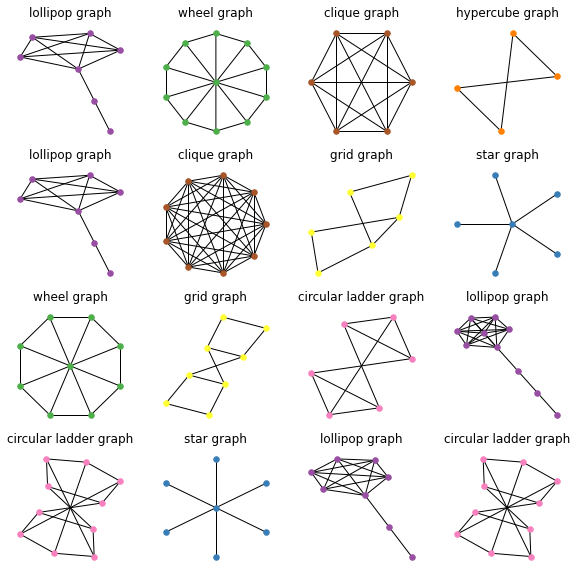

In [5]:
N = len(dataset)
plt.figure(figsize=(10, 10))
np.random.seed(0)
for i in range(16):
    plt.subplot(4, 4, i+1)
    g, l, adj = dataset[np.random.randint(N)]
    g = nx.Graph(g.to_networkx())
    g.remove_edges_from(nx.selfloop_edges(g))
    nx.draw_kamada_kawai(g, node_size=30, node_color=[plt.cm.Set1.colors[l.item()]])
    plt.title(graph_type[l.item()])

### Graph VAE

Consider the graph generation method based on Variational Autoencoder that can be used for generaion small graphs.

 Simonovsky and Komodakis [2018] https://arxiv.org/abs/1802.03480

<img src='https://raw.githubusercontent.com/netspractice/advanced_gnn/made2021/lab_deep_generation/graph_vae.png' width=800>

GCN encoder with graph pooling is used for mapping graph into the N(0, I) latent space.

In [6]:
class GaussianGCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.conv = GraphConv(input_dim, hidden_dim)
        self.mu = GraphConv(hidden_dim, output_dim)
        self.sigma = GraphConv(hidden_dim, output_dim)
        self.pooling = AvgPooling()

    def forward(self, g, features):
        h = self.conv(g, features)
        h = F.relu(h)
        mu = self.mu(g, h)
        sigma = F.softplus(self.sigma(g, h))
        return self.pooling(g, mu), self.pooling(g, sigma)

In [7]:
graph, label, adj = dataset[0]

In [8]:
encoder = GaussianGCN(input_dim=4, hidden_dim=256, output_dim=128)
z_mu, z_sigma = encoder(graph, graph.ndata['feat'])
z_mu.shape, z_sigma.shape

(torch.Size([1, 128]), torch.Size([1, 128]))

Probabilistic fully-connected graph decoder is used for reconstraction of the adjacency matrix.

In [9]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_nodes):
        super().__init__()
        self.n_nodes = n_nodes
        self.MLP = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, n_nodes**2),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = self.MLP(x)
        return x.reshape(-1, self.n_nodes, self.n_nodes)

In [10]:
decoder = MLP(input_dim=128, hidden_dim=256, n_nodes=max_num_v)
pred_adj = decoder(z_mu)
pred_adj = pred_adj[0]
pred_adj.shape

torch.Size([12, 12])

Negative ELBO (evidence lower bound) is optimized during VAE training.

In [11]:
def neg_elbo(pred_adj, adj, sigma, mu, batch_size):
    likelihood = -F.binary_cross_entropy(pred_adj, adj)
    d_kl = -(1 + torch.log(sigma**2) - mu**2 - sigma**2) * 0.5 / batch_size
    d_kl = d_kl.sum(1).mean()
    elbo = likelihood - d_kl
    return -elbo

Prepare the dataloader for the VAE training.

In [13]:
def collate(sample):
    graphs, labels, full_adj = map(list, zip(*sample))
    graph = dgl.batch(graphs)
    labels = torch.tensor(labels)
    full_adj = torch.cat(full_adj)
    return graph, labels, full_adj

batch_size = 32
train_dataloader = DataLoader(
    dataset, batch_size=batch_size, drop_last=True, collate_fn=collate, shuffle=True)

Define training method.

In [14]:
def train(encoder, decoder, dataloader, opt, batch_size, emb_dim):
    encoder.train()
    decoder.train()
    _train_loss = []
    for graph, label, full_adj in dataloader:
        mu, sigma = encoder(graph, graph.ndata['feat'])
        z = torch.randn(batch_size, emb_dim)
        z = z * sigma + mu
        pred_adj = decoder(z)
        loss = neg_elbo(pred_adj, full_adj, sigma, mu, batch_size)

        opt.zero_grad()
        loss.backward()
        opt.step()
        _train_loss.append(loss.item())
    return sum(_train_loss) / len(_train_loss)

Define models and an optimizer.

In [23]:
emb_dim = 32
encoder = GaussianGCN(input_dim=4, hidden_dim=256, output_dim=emb_dim)
decoder = MLP(input_dim=emb_dim, hidden_dim=256, n_nodes=max_num_v)
params = list(encoder.parameters()) + list(decoder.parameters())
opt = Adam(params, lr=0.005)

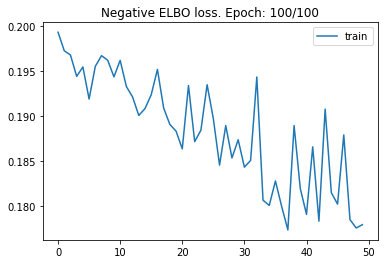

In [24]:
n_epochs = 100
train_loss = []
for epoch in range(n_epochs):
    loss = train(encoder, decoder, train_dataloader, opt, batch_size, emb_dim)
    train_loss.append(loss)
    plt.plot(train_loss[-50:], label='train')
    plt.legend()
    plt.title('Negative ELBO loss. Epoch: {}/{}'.format(epoch+1, n_epochs))
    plt.show()
    clear_output(wait=True)

Let us check the graph generation. We will descretize an adjacency matrix and drop zero colums and rows.

In [25]:
def discrete_adj(batch):
    adjs = []
    for pred_adj in batch:
        _adj = (pred_adj > 0.5).type(torch.LongTensor)
        _adj[range(max_num_v), range(max_num_v)] = 0
        mask = (_adj.sum(dim=1) != 0) | (_adj.sum(dim=0) != 0)
        adjs.append(_adj[mask, :][:, mask])
    return adjs

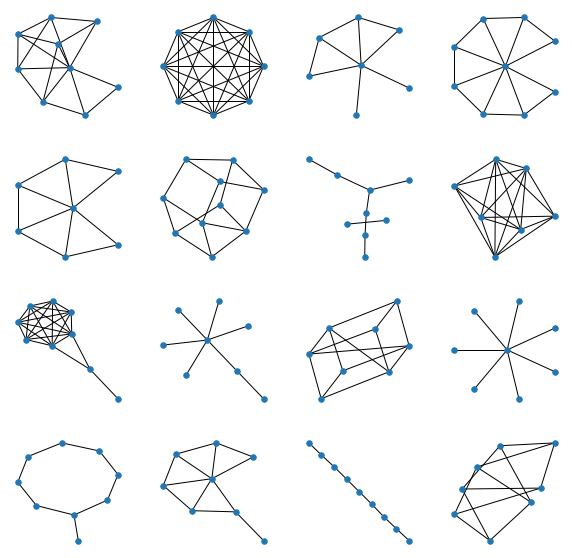

In [26]:
plt.figure(figsize=(10, 10))
z = torch.randn(16, emb_dim)
decoder.eval()
with torch.no_grad():
    pred_adj = decoder(z)
gen_adj = discrete_adj(pred_adj)
for i in range(16):
    plt.subplot(4, 4, i+1)
    G = nx.from_numpy_array(gen_adj[i].numpy())
    G.remove_edges_from(nx.selfloop_edges(G))
    nx.draw_kamada_kawai(G, node_size=30)

Let us look at the graph embedding space.

In [27]:
batch = dgl.batch([graph for graph, label, full_adj in dataset])
y = np.array([label.item() for graph, label, full_adj in dataset])
with torch.no_grad():
    encoder.eval()
    z_mu, z_sigma = encoder(batch, batch.ndata['feat'])

We will visualize embeddings using TSNE decomposition.

In [28]:
reduction = TSNE(n_components=2)
xy_emb = reduction.fit_transform(z_mu)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


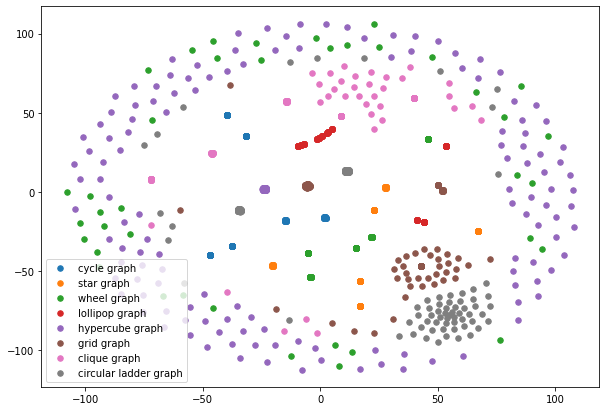

In [29]:
plt.figure(figsize=(10, 7))
for i, g_type in graph_type.items():
    plt.scatter(xy_emb[y==i, 0], xy_emb[y==i, 1], s=30, label=g_type)
plt.legend()
plt.show()

### Graph GAN

We consider the simplified Graph GAN model where we only generate the adjacency matrix.

by De Cao and Kipf [2018]

<img src='https://raw.githubusercontent.com/netspractice/advanced_gnn/made2021/lab_deep_generation/graph_gan.png' width=800>

For simplicity, consider GAN trained on the truncated dataset. Select a subsample with lollipop graphs only.

In [30]:
max_num_v = 12
dataset = OrderingGCD(
    num_graphs=800*2, 
    min_num_v=6, 
    max_num_v=max_num_v, 
    seed=0, 
    force_reload=True
)
dataset = Subset(dataset, np.arange(600, 700))

  0%|          | 0/1600 [00:00<?, ?it/s]

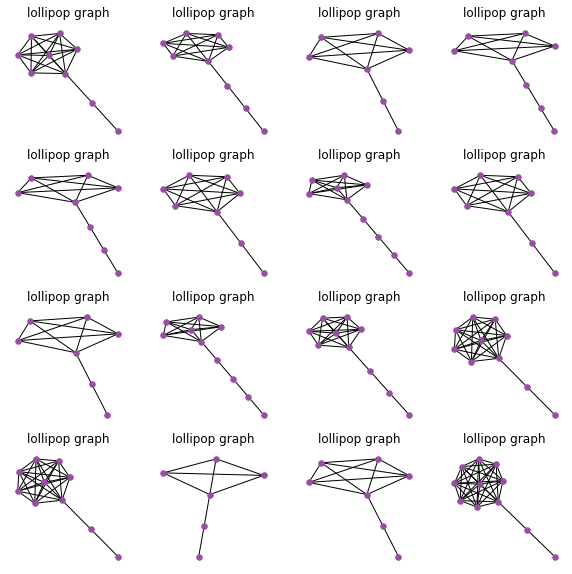

In [31]:
N = len(dataset)
plt.figure(figsize=(10, 10))
np.random.seed(0)
for i in range(16):
    plt.subplot(4, 4, i+1)
    g, l, adj = dataset[np.random.randint(N)]
    g = nx.Graph(g.to_networkx())
    g.remove_edges_from(nx.selfloop_edges(g))
    nx.draw_kamada_kawai(g, node_size=30, node_color=[plt.cm.Set1.colors[l.item()]])
    plt.title(graph_type[l.item()])

Define the dataloader.

In [222]:
batch_size = 64
train_dataloader = DataLoader(
    dataset, batch_size=batch_size, drop_last=True, collate_fn=collate, shuffle=True)

We will use two-layer GCN with an average graph pooling as a discriminator. Since we will generate adjacency matrix, and then pass them through GCN, we cannot use message passing. Thus, implement GCN on matrix multiplication.

In [32]:
class PoolingGCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.dense1 = nn.Linear(input_dim, hidden_dim)
        self.dense2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, adj, feat):
        norm = torch.diag_embed(adj.sum(dim=1)**-0.5)
        L = norm @ adj @ norm
        h = F.relu(L @ self.dense1(feat))
        h = self.dense2(h)
        return h.mean(dim=1)

In [33]:
disc = PoolingGCN(input_dim=max_num_v, hidden_dim=64, output_dim=1)

adj = torch.rand(batch_size, 12, 12)
feat = torch.rand(batch_size, 12, max_num_v)
disc(adj, feat).shape

torch.Size([32, 1])

We will generate graph by two-layer MLP.

In [34]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_nodes):
        super().__init__()
        self.n_nodes = n_nodes
        self.MLP = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, n_nodes**2),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = self.MLP(x)
        return x.reshape(-1, self.n_nodes, self.n_nodes)

In [293]:
emb_dim = 32
gen = MLP(input_dim=emb_dim, hidden_dim=256, n_nodes=max_num_v)

z = torch.randn(batch_size, emb_dim)
fake_adj = gen(z)
fake_adj.shape

torch.Size([64, 12, 12])

In [294]:
disc(fake_adj, feat).shape

torch.Size([64, 1])

In [295]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

Training consists of two steps: generator optimization and k times of discriminator optimization. We also align graphs in a mini-batch by zero columns and rows so that graphs have adjacency matrices of the same size.

In [35]:
def train(dataloader, gen, disc, gen_opt, disc_opt, batch_size, emb_dim):
    gen.train()
    disc.train()
    _gen_loss = []
    _disc_loss = []
    for real_graph, label, real_adj in dataloader:

        features = []
        adjacency = []
        for g in dgl.unbatch(real_graph):
            k = max_num_v - g.number_of_nodes()
            features.append(F.pad(g.ndata['feat'], (0, 0, 0, k))[None, ...])
            adjacency.append(F.pad(g.adj().to_dense(), (0, k, 0, k))[None, ...])
        real_adj = torch.cat(adjacency)
        real_adj[:, range(max_num_v), range(max_num_v)] = 1
        real_feat = torch.cat(features)

        real_feat = real_feat.to(device)
        real_adj = real_adj.to(device)

        for _ in range(3):
            z = torch.randn(batch_size, emb_dim, device=device)
            with torch.no_grad():
                fake_adj = gen(z)

            term1 = F.binary_cross_entropy_with_logits(
                disc(real_adj, real_feat), torch.ones(batch_size, 1, device=device))
            term2 = F.binary_cross_entropy_with_logits(
                disc(fake_adj, real_feat), torch.zeros(batch_size, 1, device=device))
            disc_loss = term1 + term2

            disc_opt.zero_grad()
            disc_loss.backward()
            disc_opt.step()

        z = torch.randn(batch_size, emb_dim, device=device)
        fake_adj = gen(z)

        gen_loss = F.binary_cross_entropy_with_logits(
            disc(fake_adj, real_feat), torch.ones(batch_size, 1, device=device))

        gen_opt.zero_grad()
        gen_loss.backward()
        gen_opt.step()
        
        _disc_loss.append(disc_loss.item())
        _gen_loss.append(gen_loss.item())

    return sum(_gen_loss)/len(_gen_loss), sum(_disc_loss)/len(_disc_loss)

In [36]:
def discrete_adj(batch):
    adjs = []
    for pred_adj in batch:
        _adj = (pred_adj > 0.5).type(torch.LongTensor)
        _adj[range(max_num_v), range(max_num_v)] = 0
        mask = (_adj.sum(dim=1) != 0) | (_adj.sum(dim=0) != 0)
        adjs.append(_adj[mask, :][:, mask])
    return adjs

Define models and optimizers.

In [298]:
emb_dim = 32
gen = MLP(input_dim=emb_dim, hidden_dim=256, n_nodes=max_num_v)
disc = PoolingGCN(input_dim=4, hidden_dim=256, output_dim=1)
gen.to(device)
disc.to(device);

In [311]:
gen_opt = Adam(gen.parameters(), lr=0.005)
disc_opt = Adam(disc.parameters(), lr=0.005)

Train the models.

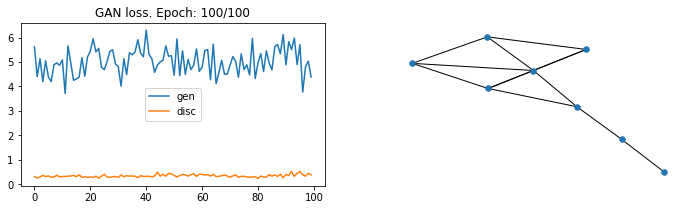

In [312]:
n_epochs = 100
gen_loss = []
disc_loss = []
for epoch in range(n_epochs):
    g_loss, d_loss = train(train_dataloader, gen, disc, gen_opt, disc_opt, batch_size, emb_dim)
    gen_loss.append(g_loss)
    disc_loss.append(d_loss)

    plt.figure(figsize=(12, 3))
    plt.subplot(1, 2, 1)
    plt.plot(gen_loss[-200:], label='gen')
    plt.plot(disc_loss[-200:], label='disc')
    plt.legend()
    plt.title('GAN loss. Epoch: {}/{}'.format(epoch+1, n_epochs))
    plt.subplot(1, 2, 2)
    z = torch.randn(1, emb_dim, device=device)
    with torch.no_grad():
        fake_adj = gen(z).cpu()
    fake_adj = discrete_adj(fake_adj)
    G = nx.from_numpy_array(fake_adj[0].numpy())
    G.remove_edges_from(nx.selfloop_edges(G))
    nx.draw_kamada_kawai(G, node_size=30)
    plt.show()
    clear_output(wait=True)

Check the generation.

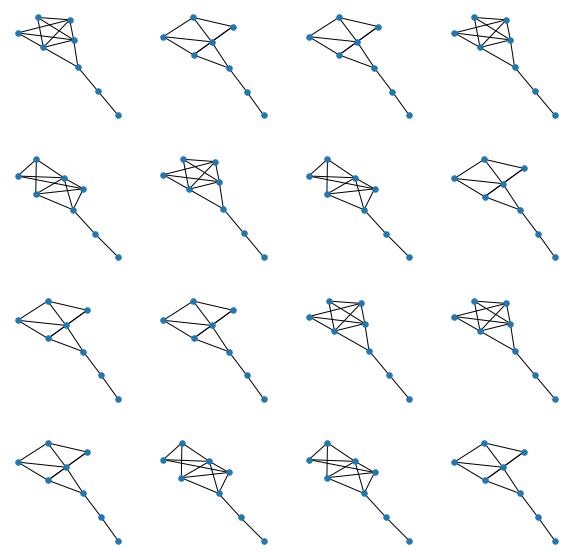

In [313]:
plt.figure(figsize=(10, 10))
z = torch.randn(batch_size, emb_dim)
gen.eval()
with torch.no_grad():
    fake_adj = gen(z)
fake_adj = discrete_adj(fake_adj)
for i in range(16):
    plt.subplot(4, 4, i+1)
    G = nx.from_numpy_array(fake_adj[i].numpy())
    G.remove_edges_from(nx.selfloop_edges(G))
    nx.draw_kamada_kawai(G, node_size=30)